Цель задания: научиться использовать в коде различные методы Transfer Learning.

Задание:
На примере датасета персонажей мультфильма Симпсонов:

Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.  

Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.  

Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.  

Оформите вывод по результатам проведённых экспериментов.
Формат сдачи работы  

Критерии оценивания
По итогу выполнения задания вы получите - зачёт/незачёт.

Задание считается выполненным, если:

LR Schedulers применяются корректно, проведено 2 эксперимента
при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась
корректно проведено обучение и дообучение любой сети (VGG, EfficientNet или MobileNet), получены сравнимые результаты или лучше по сравнению с практикой на занятии
итоговый вывод содержит подробный корректный анализ проведённых экспериментов  

Задание будет отправлено на доработку, если:  

при встраивании LR шедулеров возникли ошибки/проведено < 2 экспериментов
не удалось подобрать аугментации, сильно снижающие качество изображений/был выбран совсем тривиальный пример
не проведены эксперименты с новой архитектурой сети
вывод не написан/не подробный/содержит фактические ошибки


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

abraham_grampa_simpson, charles_montgomery_burns, milhouse_van_houten

In [4]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
#data_dir = "data/simpsons_dataset"
#data_dir = "/content/drive/MyDrive/data/simpsons_dataset"
data_dir = "/content/drive/MyDrive/data/simpsons_dataset_small" # ограничимся 3 классами для ускорения
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 2229
Изображений в val: 956


In [5]:
!ls /content/drive/MyDrive/data/simpsons_dataset_small -a

abraham_grampa_simpson	charles_montgomery_burns  milhouse_van_houten


In [6]:
#train_files_path

In [7]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [8]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  3
Количество классов в val:  3
Количество классов одинаково:  True


In [9]:
len(val_dataset.imgs)

956

In [10]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        #idx = np.random.randint(low=0, high=6000)
        idx = np.random.randint(low=0, high=(len(dataset.imgs)-1))
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

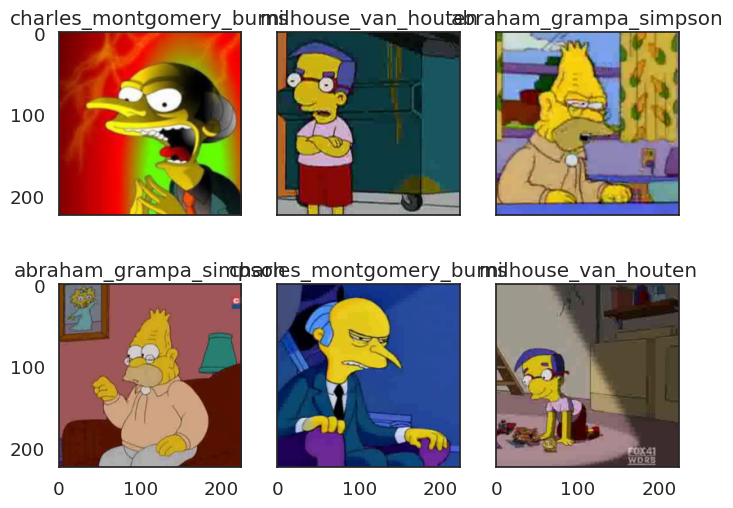

In [11]:
show_images(val_dataset)

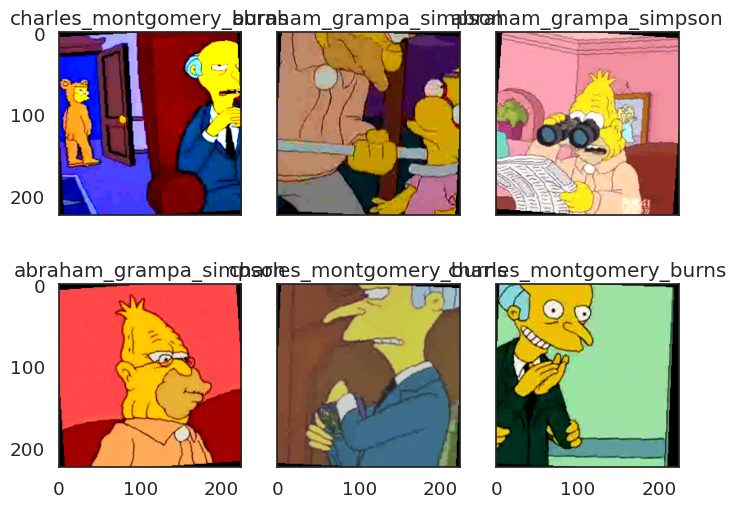

In [12]:
show_images(train_dataset)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [15]:
def train_scheduler_epoch(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
######### Вызываем шаг шедъюлера после каждой эпохи
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy()) # detach() используется на всякий случай, что бы случайно не скопировать вместе с одной цифрой
            y_pred = logits.max(1)[1].detach().cpu().numpy() # все, связанные с ней матрицы градиентов, и не отжирать напрасно память (здесь возможно не нужно, но лучше ставить)
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output() # чистим предыдущий вывод в консоль, что бы отображался только последний вывод картинок

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [16]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
#train_batch_gen = torch.utils.data.DataLoader(
#    train_dataset_min, batch_size=batch_size, shuffle=True
#)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
#val_batch_gen = torch.utils.data.DataLoader(
#    val_dataset_min, batch_size=batch_size, shuffle=False
#)

In [17]:
from torchvision.models import resnet18

Обучим `Resnet18` с нуля  

1) Применим lr_scheduler.StepLR шедъюлер.

In [18]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [20]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

Epoch 10 of 10 took 29.886s
  training loss (in-iteration): 	0.987526
  validation loss (in-iteration): 	0.947078
  training accuracy: 			53.41 %
  validation accuracy: 			61.15 %


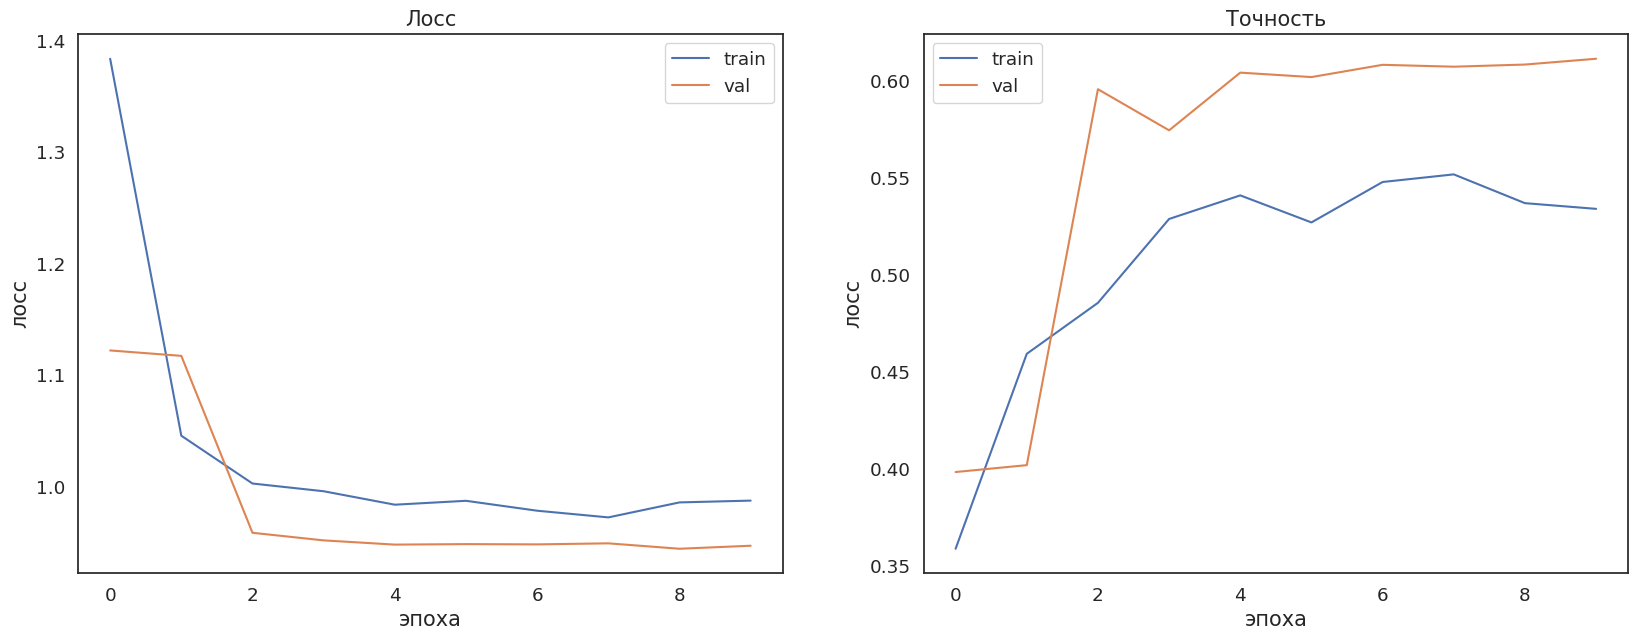

CPU times: user 4min 23s, sys: 17 s, total: 4min 40s
Wall time: 15min 24s


In [21]:
%%time
clf_model, history = train_scheduler_epoch(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Видно, что при адаптации с гамммой 0,1 уже после 2 шага пррогресс обучения сильно уменьшается, а после 4 факсически сходит на нет за счет снижения lr по арифмитической прогрессии.

2) Применим lr_scheduler.ExponentialLR шедъюлер.

In [22]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6, last_epoch=-1)

Epoch 10 of 10 took 29.873s
  training loss (in-iteration): 	0.965106
  validation loss (in-iteration): 	0.919963
  training accuracy: 			54.24 %
  validation accuracy: 			62.81 %


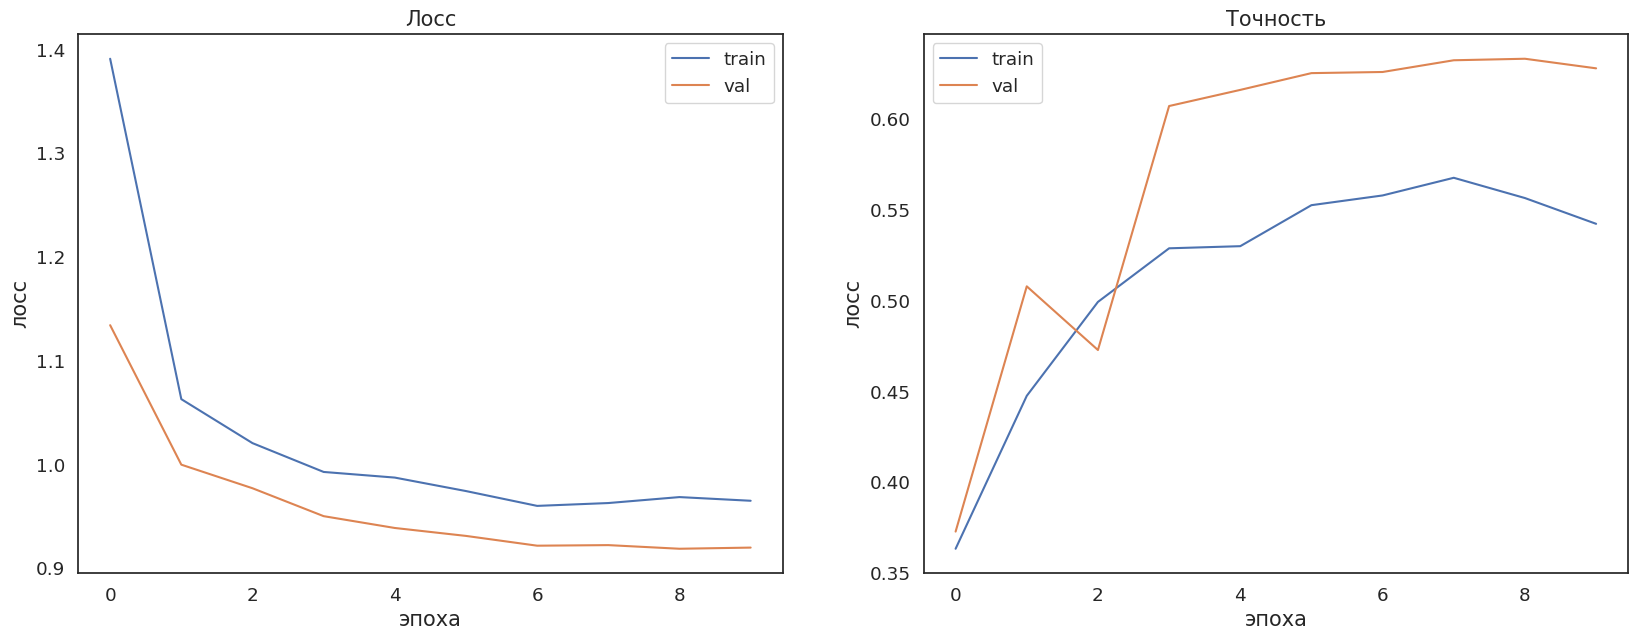

CPU times: user 4min 19s, sys: 15.6 s, total: 4min 34s
Wall time: 5min 6s


In [25]:
%%time
clf_model, history = train_scheduler_epoch(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Попробовал, что при изминении параметра гаммма степень кривизны графиков меняется.

3) Применим lr_scheduler.CyclicLR шедъюлер.

In [26]:
def train_scheduler_batch(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
######### Вызываем шаг шедъюлера после каждого батча
            scheduler.step()



        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy()) # detach() используется на всякий случай, что бы случайно не скопировать вместе с одной цифрой
            y_pred = logits.max(1)[1].detach().cpu().numpy() # все, связанные с ней матрицы градиентов, и не отжирать напрасно память (здесь возможно не нужно, но лучше ставить)
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output() # чистим предыдущий вывод в консоль, что бы отображался только последний вывод картинок

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [27]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [29]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

Epoch 10 of 10 took 29.912s
  training loss (in-iteration): 	0.446546
  validation loss (in-iteration): 	0.814450
  training accuracy: 			81.85 %
  validation accuracy: 			70.69 %


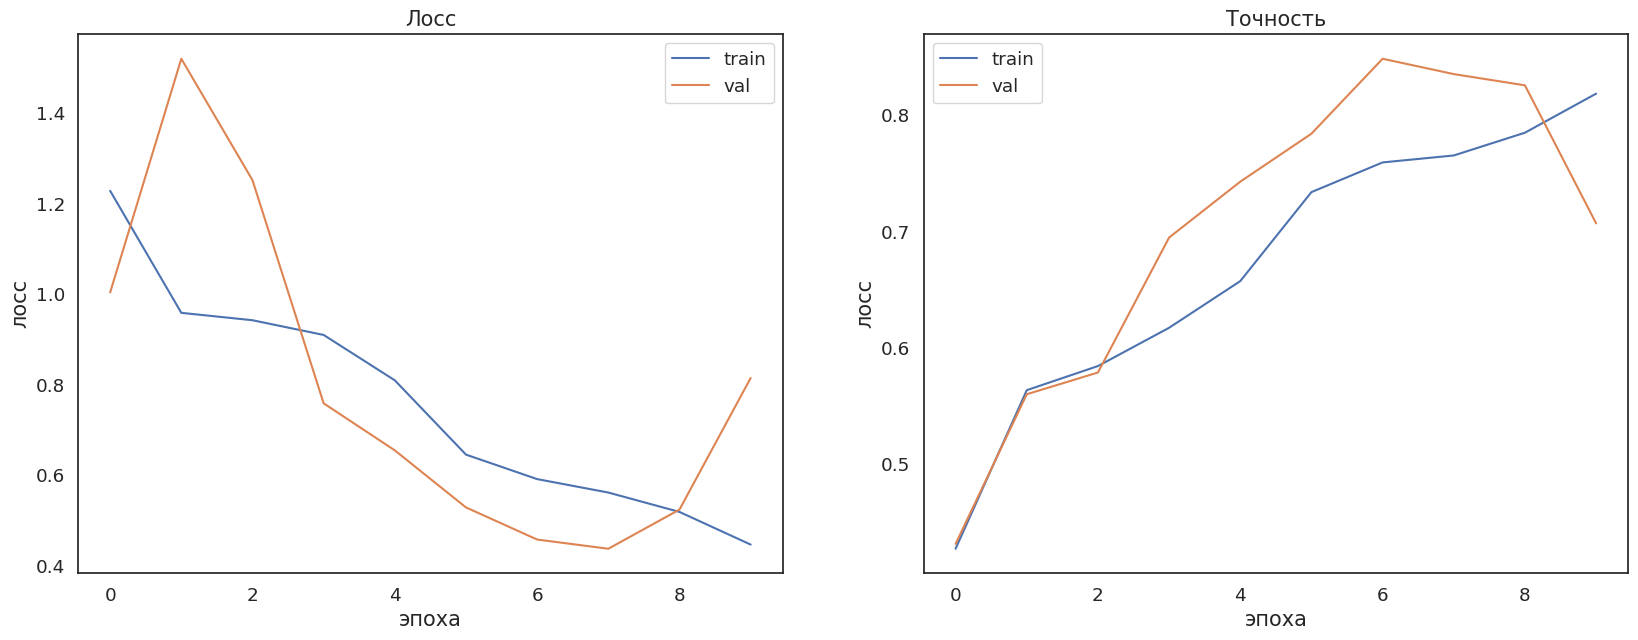

CPU times: user 4min 19s, sys: 15.8 s, total: 4min 35s
Wall time: 5min 5s


In [30]:
%%time
clf_model, history = train_scheduler_epoch(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Пила циклического изменения адаптации lr хорошо видна, и видно, что изменение только этого параметра позволило достичь более хорошего обучения. Видимо за счет сложного маршрута модель нашла лучшую область минимума на гиперповерхности.

### Теперь помучаем трансформации.

###Усложним наши трансформации.

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomHorizontalFlip(p=0.5), # перевернем
    transforms.RandomVerticalFlip(p=0.5), # перевернем
    #transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.ColorJitter((0.5,0.9), (0.5,0.9), (0.5,0.9), (-0.3,0.3)),
    #transforms.RandomAffine(5),
    transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)), # покрутим, повертим буквально все
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
#train_batch_gen = torch.utils.data.DataLoader(
#    train_dataset_min, batch_size=batch_size, shuffle=True
#)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
#val_batch_gen = torch.utils.data.DataLoader(
#    val_dataset_min, batch_size=batch_size, shuffle=False
#)

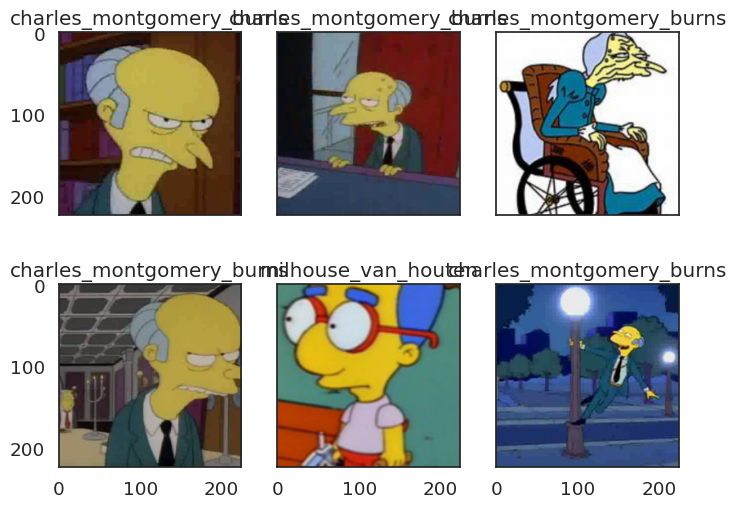

In [ ]:
show_images(val_dataset)

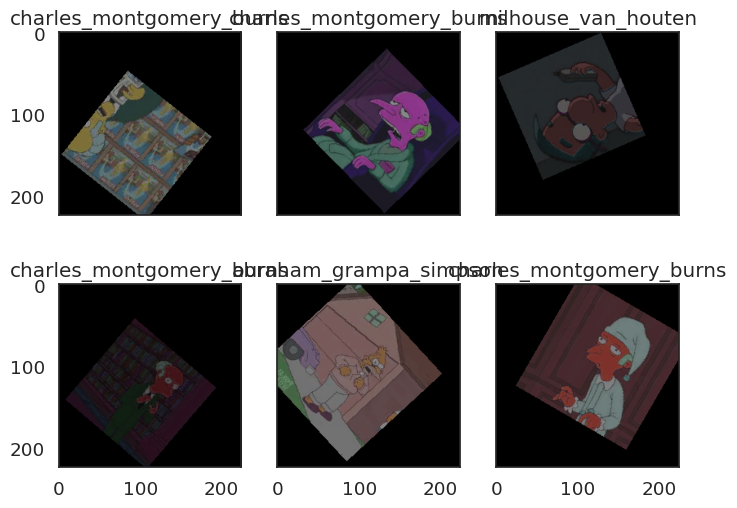

In [ ]:
show_images(train_dataset)

Все ужасно неоригинально получилось.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy()) # detach() используется на всякий случай, что бы случайно не скопировать вместе с одной цифрой
            y_pred = logits.max(1)[1].detach().cpu().numpy() # все, связанные с ней матрицы градиентов, и не отжирать напрасно память (здесь возможно не нужно, но лучше ставить)
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output() # чистим предыдущий вывод в консоль, что бы отображался только последний вывод картинок

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
model = resnet18(pretrained=False)
#model.fc = nn.Linear(512, 42)
model.fc = nn.Linear(512, 3)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Epoch 10 of 10 took 38.891s
  training loss (in-iteration): 	0.923738
  validation loss (in-iteration): 	1.172336
  training accuracy: 			57.79 %
  validation accuracy: 			51.80 %


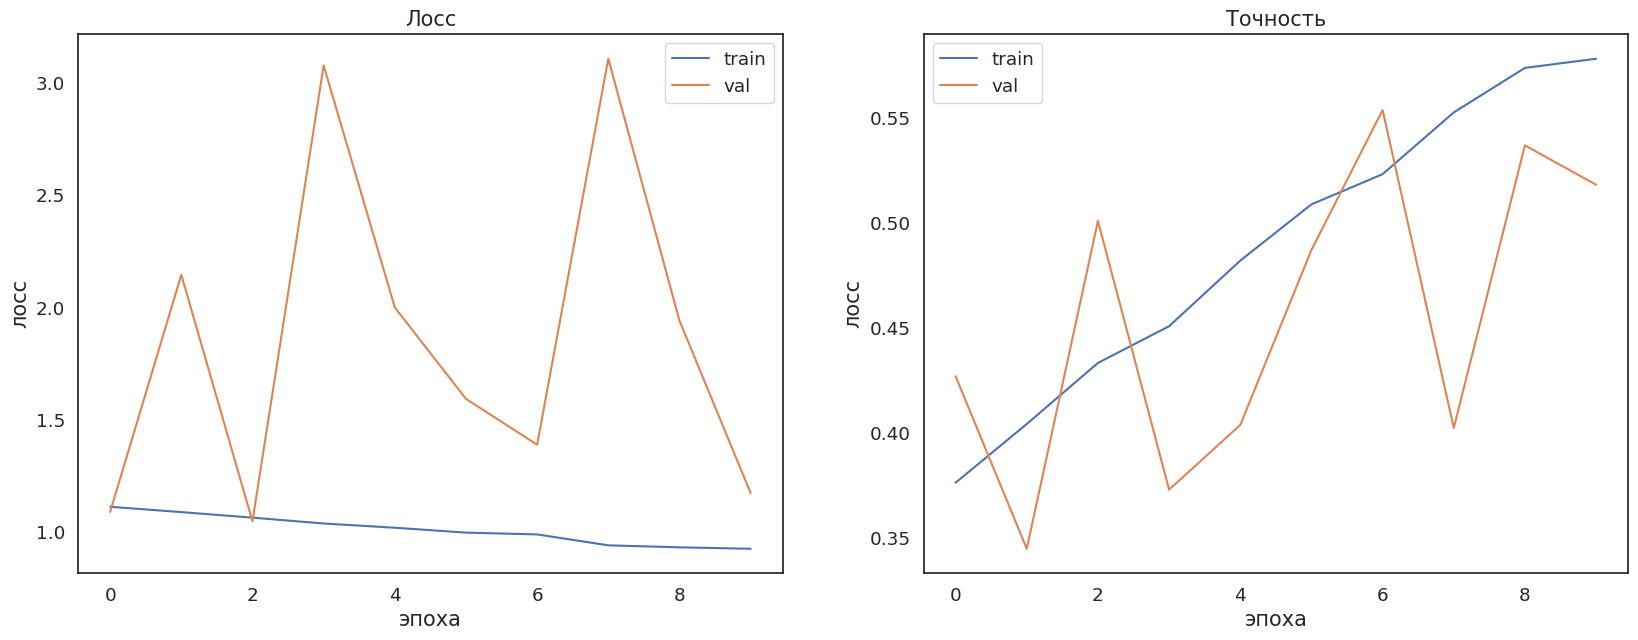

CPU times: user 5min 44s, sys: 13.7 s, total: 5min 58s
Wall time: 6min 30s


In [ ]:
%%time
clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Благодаря аугментации все на первых эпохах получилось достаточно непредсказуемо. Валидация с эталонными картинками шарахается из стороны в сторону а тренировочная выборка, несмотря на обеспеченное разнообразие гладкая. Общая тенденция при этом положительная и возможно при более длительном обучении ломанная разгладится.